# Credit Risk Analysis

### Importing libraries

In [1]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [2]:
filepath = os.path.join('..', 'resources', 'df_criado_final.csv')
df = pd.read_csv(filepath, delimiter=',')

In [3]:
df.head()

,Escolaridade,Renda Mensal Informal,Dependentes,Estado Civil,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,...,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado
0,NaN,NaN,S,2,36,S,N,NaN,NaN,N,...,8174.32,263.25,5844.98,14282.55,1,1,1328587.0,1,2020-01-01,57
1,1.0,1894.5078,N,2,39,S,N,2.0,1.0,S,...,41775.63,1607.29,7652.26,51035.18,1,1,1424254.0,1,2020-01-01,59
2,1.0,NaN,S,2,26,S,N,NaN,1.0,S,...,522940.27,24860.40,319315.62,867116.29,1,1,1438519.0,0,2020-01-01,56
3,NaN,NaN,N,8,23,N,N,NaN,NaN,N,...,1593.00,21472.36,2967.48,26032.84,1,1,1426138.0,1,2020-01-01,56
4,NaN,NaN,S,2,33,S,N,NaN,NaN,N,...,2078.97,19.44,46.35,2144.76,1,1,1474504.0,0,2020-01-01,59


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Renda Mensal Informal        9768 non-null   float64
 2   Dependentes                  50390 non-null  object 
 3   Estado Civil                 50390 non-null  int64  
 4   Idade                        50390 non-null  int64  
 5   Conta Poupanca               50390 non-null  object 
 6   Conta Salario                50390 non-null  object 
 7   Quant Adiantamento Deposito  21843 non-null  float64
 8   Qtd Fonte Renda              12806 non-null  float64
 9   Cheque Sem Fundo             50390 non-null  object 
 10  Conta Conjunta               50390 non-null  object 
 11  Valor Conta Corrente         0 non-null      float64
 12  Valor Conta Poupanca         0 non-null      float64
 13  Valor Emprestimo

In [5]:
{ col: df[col].unique().size for col in df.columns }

{'Escolaridade': 4,
 'Renda Mensal Informal': 2342,
 'Dependentes': 2,
 'Estado Civil': 9,
 'Idade': 77,
 'Conta Poupanca': 2,
 'Conta Salario': 2,
 'Quant Adiantamento Deposito': 16,
 'Qtd Fonte Renda': 4,
 'Cheque Sem Fundo': 2,
 'Conta Conjunta': 2,
 'Valor Conta Corrente': 1,
 'Valor Conta Poupanca': 1,
 'Valor Emprestimo': 28577,
 'Multa': 33777,
 'Juros': 42139,
 'Valor Emprestimo Atualizado': 43191,
 'PAGO': 2,
 'Controle': 1,
 'ID': 45784,
 'Genero': 2,
 'Data': 1,
 'Estado': 4}

In [6]:
df.isnull().mean()

Escolaridade                   0.709962
Renda Mensal Informal          0.806152
Dependentes                    0.000000
Estado Civil                   0.000000
Idade                          0.000000
Conta Poupanca                 0.000000
Conta Salario                  0.000000
Quant Adiantamento Deposito    0.566521
Qtd Fonte Renda                0.745862
Cheque Sem Fundo               0.000000
Conta Conjunta                 0.000000
Valor Conta Corrente           1.000000
Valor Conta Poupanca           1.000000
Valor Emprestimo               0.000000
Multa                          0.000000
Juros                          0.000000
Valor Emprestimo Atualizado    0.000000
PAGO                           0.000000
Controle                       0.000000
ID                             0.000000
Genero                         0.000000
Data                           0.000000
Estado                         0.000000
dtype: float64

### Removing features

In [5]:
# Removing features with unique values
unique_value_features = [col for col in df.columns if df[col].unique().size == 1]
df = df.drop(columns=unique_value_features, errors='ignore')

# Removing features not related to credit risk
not_related_features = ['ID']
df = df.drop(columns=not_related_features, errors='ignore')

# Removing columns with a proportion of missing values above a threshold
above_percentage_nan_features = [col for col in df.columns if df[col].isnull().mean() >= 0.8]
df = df.drop(columns=above_percentage_nan_features, errors='ignore')

### Handling missing values

In [6]:
df = df.fillna(0)

### Distribution for each feature

In [12]:
# fig = plt.figure(figsize = (25, 25))

# for i, col in enumerate(df.columns):
#     plt.subplot((df.columns.size // 4) + 1, 4, i + 1)
#     sns.distplot(df[col][df['PAGO']==0], color='g', label='Pago')
#     sns.distplot(df[col][df['PAGO']==1], color='r', label='Não pago')
#     plt.legend(loc='best')

# fig.suptitle('')
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# plt.show()

### Correlation between features

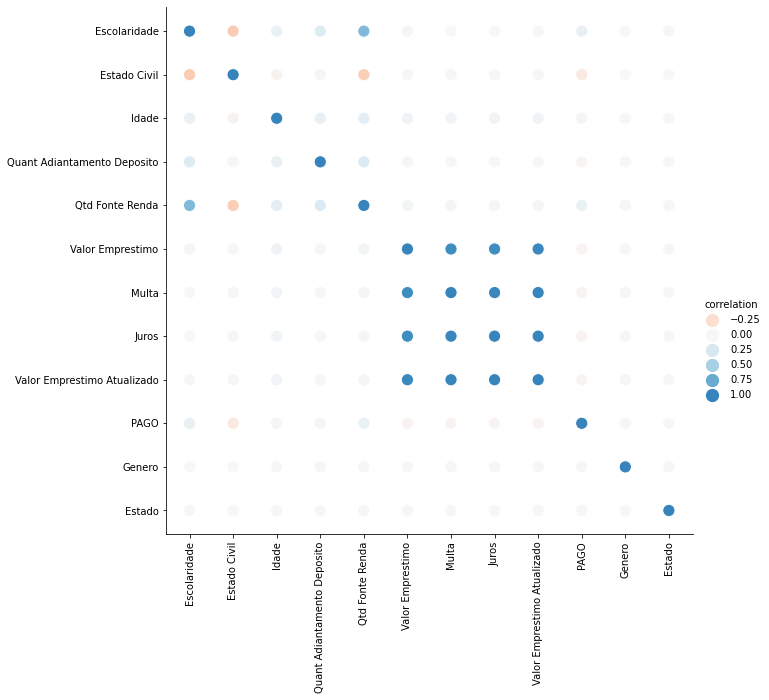

In [8]:
corr = df.corr().stack().reset_index(name='correlation')

g_corr = sns.relplot(
    data=corr, x='level_0', y='level_1', hue='correlation', size='correlation', palette='RdBu',
    hue_norm=(-1.5, 1.5), height=10, sizes=(150, 150), size_norm=(-.2, .8))

g_corr.set(xlabel='', ylabel='', aspect='equal')
for label in g_corr.ax.get_xticklabels():
    label.set_rotation(90)

In [10]:
df.columns

Index(['Escolaridade', 'Dependentes', 'Estado Civil', 'Idade',
       'Conta Poupanca', 'Conta Salario', 'Quant Adiantamento Deposito',
       'Qtd Fonte Renda', 'Cheque Sem Fundo', 'Conta Conjunta',
       'Valor Emprestimo', 'Multa', 'Juros', 'Valor Emprestimo Atualizado',
       'PAGO', 'Genero', 'Estado'],
      dtype='object')

### Splitting dataset

In [181]:
X = df.drop('PAGO', axis=1)
y = df['PAGO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### One-hot encoding categorical features

In [37]:
categorical_features = ['Escolaridade', 'Dependentes', 'Estado Civil', 'Conta Poupanca', 'Conta Salario',
    'Cheque Sem Fundo', 'Conta Conjunta', 'Genero', 'Estado']

for col in categorical_features:
    one_hot_col = pd.get_dummies(df[col], prefix=col)
    df = df.drop(col, axis=1).join(one_hot_col)